In [1]:
from pymongo import MongoClient
import datetime
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import pickle

client = MongoClient()
db = client["reddit_polarization"]
sw = pickle.load(open("stoplist.pickle"))

In [2]:
men = pd.DataFrame(list(db["MensRights"].find({}, {"score": 1, "tokens_njv_pos": 1, "_id": 0})))
fem = pd.DataFrame(list(db["Feminism"].find({}, {"score": 1, "tokens_njv_pos": 1, "_id": 0})))
print men.shape, fem.shape

(2452716, 2) (213100, 2)


In [3]:
min_words = 20

In [4]:
def pos_filter(x, keep=set("NJ")):
    if len(x) == 0:
        return ""
    
    tokens_pos = x.split(" ")
    tokens_pos = map(lambda pair: pair.split("/"), tokens_pos)
    
    tokens_pos = filter(lambda pair: pair[1] in keep, tokens_pos)

    if len(tokens_pos) == 0:
        return ""
    
    return " ".join(zip(*tokens_pos)[0])

In [5]:
def clean_token_pos(text):
    text = pos_filter(text)
    out = " ".join(filter(lambda x: x not in sw, text.split(" ")))
    return out

In [6]:
men["corpus"] = men["tokens_njv_pos"].map(clean_token_pos)
fem["corpus"] = fem["tokens_njv_pos"].map(clean_token_pos)

In [7]:
men = men[men["corpus"].map(lambda x: len(x.split(" "))) >= min_words]
fem = fem[fem["corpus"].map(lambda x: len(x.split(" "))) >= min_words]

In [8]:
men.shape, fem.shape

((480773, 3), (55414, 3))

In [9]:
men = men.sort_values("score", ascending=False)
fem = fem.sort_values("score", ascending=False)

In [10]:
size = 5000

men_x_corpus = men[:size][["corpus", "score"]]
fem_x_corpus = fem[:size][["corpus", "score"]]
men_x_corpus = men_x_corpus.reset_index(drop=True)
fem_x_corpus = fem_x_corpus.reset_index(drop=True)
men_x_corpus["tag"] = men_x_corpus.apply(lambda row: "men_" + str(row.name), axis=1)
fem_x_corpus["tag"] = fem_x_corpus.apply(lambda row: "fem_" + str(row.name), axis=1)

print men_x_corpus.shape, fem_x_corpus.shape

(5000, 3) (5000, 3)


In [11]:
men_x_corpus[:3]

,corpus,score,tag
0,male usa sexual harassment complaint school qu...,2332,men_0
1,time reddit discriminationmen post mod part ac...,2182,men_1
2,link issue pay gap widely-cited disadvantage w...,1928,men_2


In [12]:
fem_x_corpus[:3]

,corpus,score,tag
0,reading scattered article girl report sexual a...,490,fem_0
1,quick history lesson men movement complement f...,477,fem_1
2,funny math post dead wrong chance false accusa...,312,fem_2


In [13]:
men_x_corpus["score"].min(), men_x_corpus["score"].max()

(49, 2332)

In [14]:
fem_x_corpus["score"].min(), fem_x_corpus["score"].max()

(10, 490)

In [15]:
len(men_x_corpus), len(fem_x_corpus)

(5000, 5000)

In [16]:
men[:3]

,score,tokens_njv_pos,corpus
1857232,2332,male/J usa/N make/V sexual/J harassment/N comp...,male usa sexual harassment complaint school qu...
863209,2182,happen/V time/N reddit/N discriminationmen/N r...,time reddit discriminationmen post mod part ac...
1477233,1928,link/N issue/N pay/N gap/N widely-cited/J exam...,link issue pay gap widely-cited disadvantage w...


In [17]:
fem[:3]

,score,tokens_njv_pos,corpus
184223,490,reading/N scattered/J article/N girl/N report/...,reading scattered article girl report sexual a...
37726,477,quick/J history/N lesson/N men/N movement/N or...,quick history lesson men movement complement f...
20435,312,funny/J math/N post/N dead/J wrong/J chance/N ...,funny math post dead wrong chance false accusa...


In [18]:
train_sents = list(pd.concat([men_x_corpus, fem_x_corpus], axis=0)["corpus"].values)

In [19]:
y = np.r_[np.ones(len(men_x_corpus)), np.zeros(len(fem_x_corpus))]

In [20]:
men_x_corpus.shape, fem_x_corpus.shape, y.shape

((5000, 3), (5000, 3), (10000,))

In [21]:
background = list(pd.concat([men, fem], axis=0)["corpus"].values)

In [22]:
background[:2]

[u'male usa sexual harassment complaint school question hostile environment men violates equal education basis sex discrimination retaliation school illegal complaint hard answer wrong',
 u'time reddit discriminationmen post mod part active reddit censorship rundelete til male victim domestic violence law enforcement female national institute health pdf twitter twitter people pro-sjwfeminist position academia medical school censor study percent domestic violence woman men narrative edit south african prison rape survivor time']

In [23]:
train_sents[:2]

[u'male usa sexual harassment complaint school question hostile environment men violates equal education basis sex discrimination retaliation school illegal complaint hard answer wrong',
 u'time reddit discriminationmen post mod part active reddit censorship rundelete til male victim domestic violence law enforcement female national institute health pdf twitter twitter people pro-sjwfeminist position academia medical school censor study percent domestic violence woman men narrative edit south african prison rape survivor time']

In [24]:
len(train_sents), len(background)

(10000, 536187)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

n_topics = [32, 64, 128, 256, 512, 1024]
lsi = Pipeline([("tfidf", TfidfVectorizer(analyzer='word', stop_words="english", max_features=4096)),
                    ("svd", TruncatedSVD(random_state=123)), 
                    ("normalizer", StandardScaler())])

for n in n_topics:
    lsi.set_params(svd__n_components=n)
    X = lsi.fit_transform(train_sents)
    print X.shape
    lr = LogisticRegression(random_state=123)
    
    print "Num of Topics = %d, accuracy = %f" % (n, np.mean(cross_val_score(lr, X, y, cv=10)))

(10000, 32)
Num of Topics = 32, accuracy = 0.667300
(10000, 64)
Num of Topics = 64, accuracy = 0.676400
(10000, 128)
Num of Topics = 128, accuracy = 0.692200
(10000, 256)
Num of Topics = 256, accuracy = 0.704600
(10000, 512)
Num of Topics = 512, accuracy = 0.713700
(10000, 1024)
Num of Topics = 1024, accuracy = 0.711500


In [26]:
from gensim.models.doc2vec import Doc2Vec, LabeledSentence

class PolarizedPost(object):
    def __init__(self, men_x_corpus, fem_x_corpus):
        self.data = (("men", men_x_corpus), ("fem", fem_x_corpus))
    def __iter__(self):        
        for subreddit, df in self.data:
            for i in range(df.shape[0]):
                text = df.iat[i, 0]
                sent_tag = df.iat[i, 2]
                yield LabeledSentence(text.split(), [sent_tag])

In [27]:
pp = PolarizedPost(men_x_corpus, fem_x_corpus)
lpp = list(iter(pp))
lpp[:2]

[TaggedDocument(words=[u'male', u'usa', u'sexual', u'harassment', u'complaint', u'school', u'question', u'hostile', u'environment', u'men', u'violates', u'equal', u'education', u'basis', u'sex', u'discrimination', u'retaliation', u'school', u'illegal', u'complaint', u'hard', u'answer', u'wrong'], tags=['men_0']),
 TaggedDocument(words=[u'time', u'reddit', u'discriminationmen', u'post', u'mod', u'part', u'active', u'reddit', u'censorship', u'rundelete', u'til', u'male', u'victim', u'domestic', u'violence', u'law', u'enforcement', u'female', u'national', u'institute', u'health', u'pdf', u'twitter', u'twitter', u'people', u'pro-sjwfeminist', u'position', u'academia', u'medical', u'school', u'censor', u'study', u'percent', u'domestic', u'violence', u'woman', u'men', u'narrative', u'edit', u'south', u'african', u'prison', u'rape', u'survivor', u'time'], tags=['men_1'])]

In [28]:
models = [Doc2Vec(dm=0, dbow_words=1, min_count=1, window=15,
                  size=100, sample=1e-5, iter=20, workers=4), # Distributed BOW
          Doc2Vec(dm=1, dm_mean=1, min_count=1, window=10,
                  size=100, sample=1e-5, iter=20, workers=4)] # Distributed Memory

names = ["Distributed BOW", "Distributed Memory"]
model = models[0]
name = names[0]

In [29]:
print "%s: %s" % (name, str(model))
corpus = PolarizedPost(men_x_corpus, fem_x_corpus)
model.build_vocab(corpus)
corpus = PolarizedPost(men_x_corpus, fem_x_corpus)
model.train(corpus)

Distributed BOW: Doc2Vec(dbow+w,d100,n5,w15,s1e-05,t4)


2901456

In [35]:
model.most_similar("subreddit")

[(u'upvotes', 0.9536874294281006),
 (u'sidebar', 0.9455153346061707),
 (u'upvoted', 0.9451340436935425),
 (u'moderation', 0.9397003650665283),
 (u'subscriber', 0.937361478805542),
 (u'rfeminisms', 0.9324629306793213),
 (u'troll', 0.9324445128440857),
 (u'derailing', 0.9294870495796204),
 (u'anti-mra', 0.9271706938743591),
 (u'rwindows', 0.9218843579292297)]

In [36]:
X = np.array([model.docvecs[tagged_sent.tags[0]] for tagged_sent in lpp])

In [37]:
X.shape

(10000, 100)

In [38]:
tag2id = {lpp[i].tags[0]: i for i in range(len(lpp))}

In [39]:
from sklearn.preprocessing import StandardScaler

clf = Pipeline([("normalizer", Normalizer()), ("lr", LogisticRegression())])

In [40]:
np.mean(cross_val_score(clf, X, y, cv=10))

0.64429999999999998

In [41]:
from sklearn.manifold import TSNE, MDS

In [ ]:
tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X)

In [51]:
X_tsne.shape

(10000, 2)

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
men_index = [tag2id[tag] for tag in men_x_corpus["tag"][:200]]

In [54]:
fem_index = [tag2id[tag] for tag in fem_x_corpus["tag"][:200]]

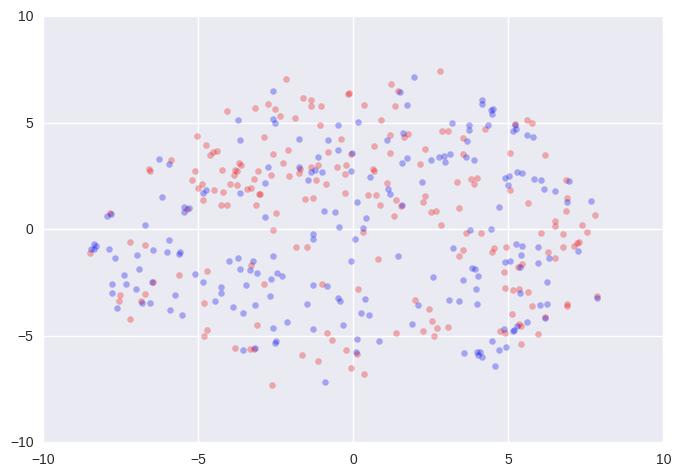

In [58]:
plt.scatter(X_tsne[men_index, 0], X_tsne[men_index, 1], c="r", alpha=0.3, linewidths=0.1)
plt.scatter(X_tsne[fem_index, 0], X_tsne[fem_index, 1], c="b", alpha=0.3, linewidths=0.1)
plt.show()

In [29]:
len(background)

536187

In [62]:
def corpus2counter(corpus):
    c = Counter()
    for text in corpus:
        tokens = text.split(" ")
        tokens = filter(lambda x: len(x) > 0, tokens)
        c.update(tokens)
    return c    

In [63]:
def zscore(word, counter_i, n_i, 
           counter_j, n_j,
           counter_0, n_0, log=np.log):
    """
    Input: the counter of words in corpus_i and corpus_j, and their sizes(n_i and n_j)
           the counter of words in background corpus_0, and size (n_0)
           
    Function for computing the log-odds ratio. The LARGER the zscore, the MORE overrepresented
    the word `word` is in corpus_i as opposed in corpus_j
    """
    y_i = np.float(counter_i[word])
    y_j = np.float(counter_j[word])
    a_w = np.float(counter_0[word])

    ratio_i = (y_i + a_w) / (n_i + n_0 - y_i - a_w)
    ratio_j = (y_j + a_w) / (n_j + n_0 - y_j - a_w)

    if ratio_i < 0.:
        raise ValueError("ratio_i is negative: %f\n" % ratio_i)
    if ratio_j < 0.:
        raise ValueError("ratio_j is negative: %f\n" % ratio_j)

    logratio = log(ratio_i) - log(ratio_j)

    try:
        var_logratio = 1. / (y_i + a_w) + 1. / (y_j + a_w)
    except ZeroDivisionError as inst:
        print inst

    try:
        z = logratio / np.sqrt(var_logratio)
    except Exception as inst:
        print inst

    return z

In [64]:
men_counter = corpus2counter(men_x_corpus["corpus"])
fem_counter = corpus2counter(fem_x_corpus["corpus"])

In [65]:
background_counter = corpus2counter(background)

In [66]:
n_i = sum(men_counter.values())
n_j = sum(fem_counter.values())
n_0 = sum(background_counter.values())

In [67]:
n_i, n_j, n_0

(229382, 222444, 23819604)

In [68]:
common = set(men_counter.keys()) & set(fem_counter.keys())
common = list(common)

In [69]:
df = [(w, zscore(w, counter_i=men_counter, n_i=n_i,
                 counter_j=fem_counter, n_j=n_j,
                 counter_0=background_counter, n_0=n_0)) for w in common]

In [70]:
df = pd.DataFrame(np.array(zip(*df)).T, columns=["word", "zscore"])
df["zscore"] = df["zscore"].astype(np.float)
df = df.sort_values(by="zscore")

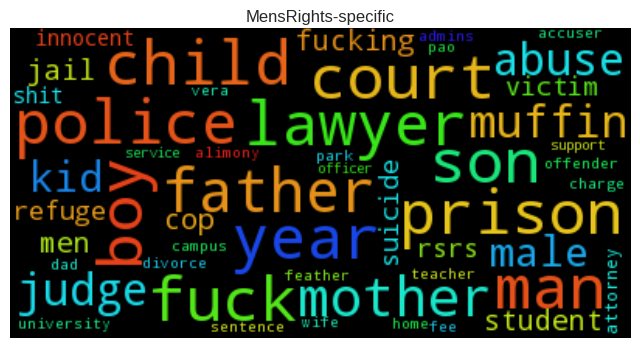

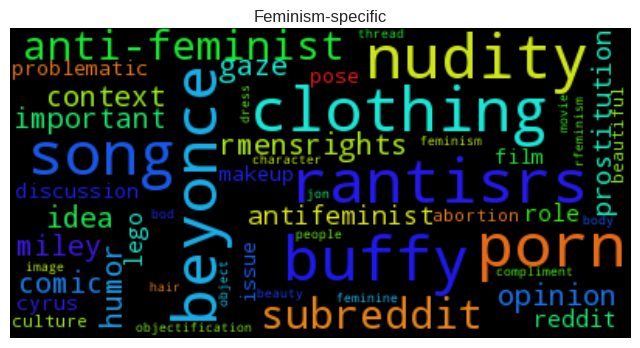

In [71]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

men = dict(df.iloc[-50:, :].values)
fem = dict(df.iloc[:50, :].values)

wc_men = WordCloud(max_font_size=40).generate_from_frequencies((k, men[k]) for k in men.keys())
wc_fem = WordCloud(max_font_size=40).generate_from_frequencies((k, fem[k]) for k in fem.keys())

plt.imshow(wc_men)
plt.title("MensRights-specific")
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(wc_fem)
plt.title("Feminism-specific")
plt.xticks([])
plt.yticks([])
plt.show()

In [159]:
top = 200

In [160]:
X = np.array([model[w] for w in df["word"][:top]] + [model[w] for w in df["word"][-top:]])

In [161]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

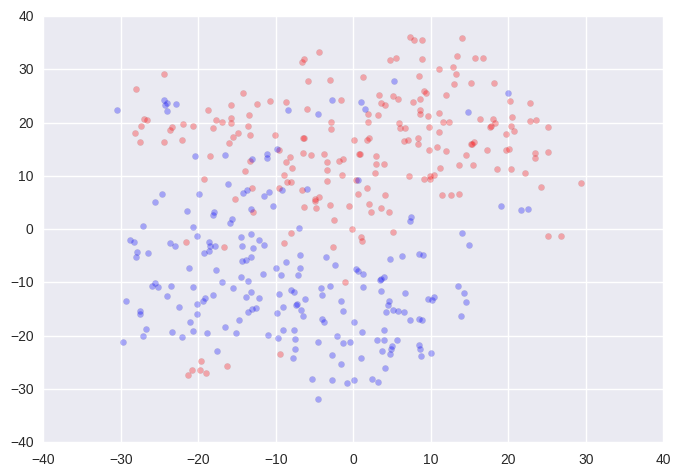

In [162]:
plt.scatter(X_tsne[:top, 0], X_tsne[:top, 1], c="r", alpha=0.3, linewidths=0.1)
plt.scatter(X_tsne[top:, 0], X_tsne[top:, 1], c="b", alpha=0.3, linewidths=0.1)
plt.show()